# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('kfold_res_aug_nodp_1e-4')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 34.3 s, sys: 30.8 s, total: 1min 5s
Wall time: 6.84 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

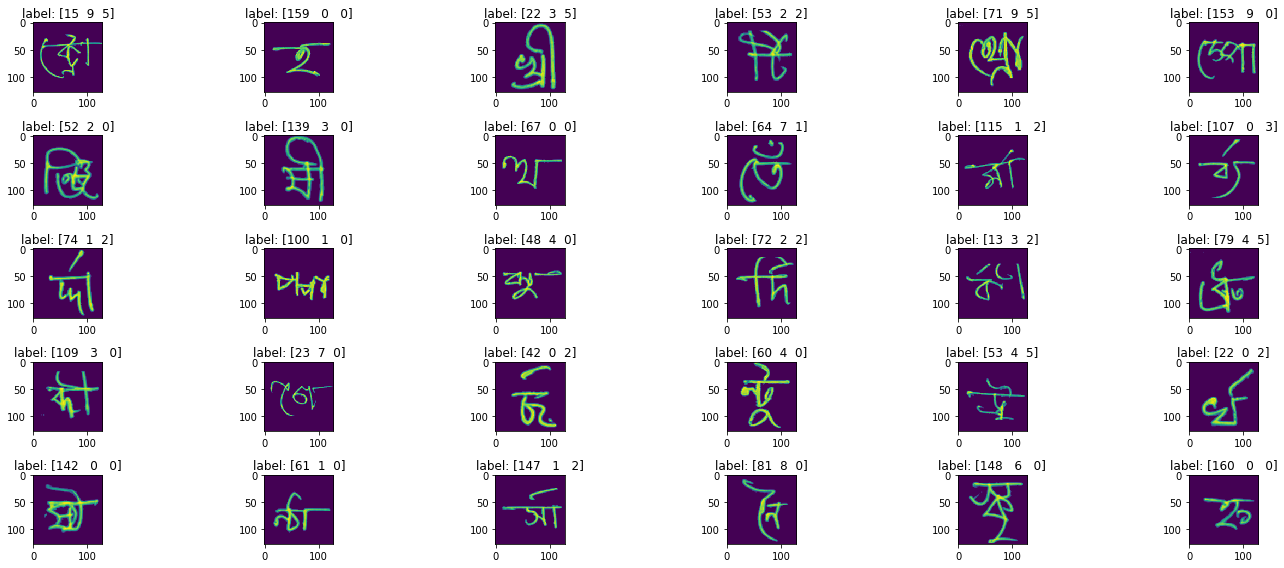

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

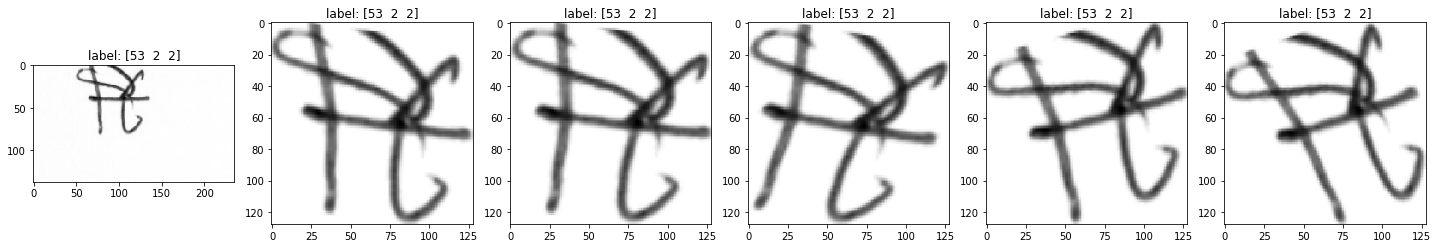

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

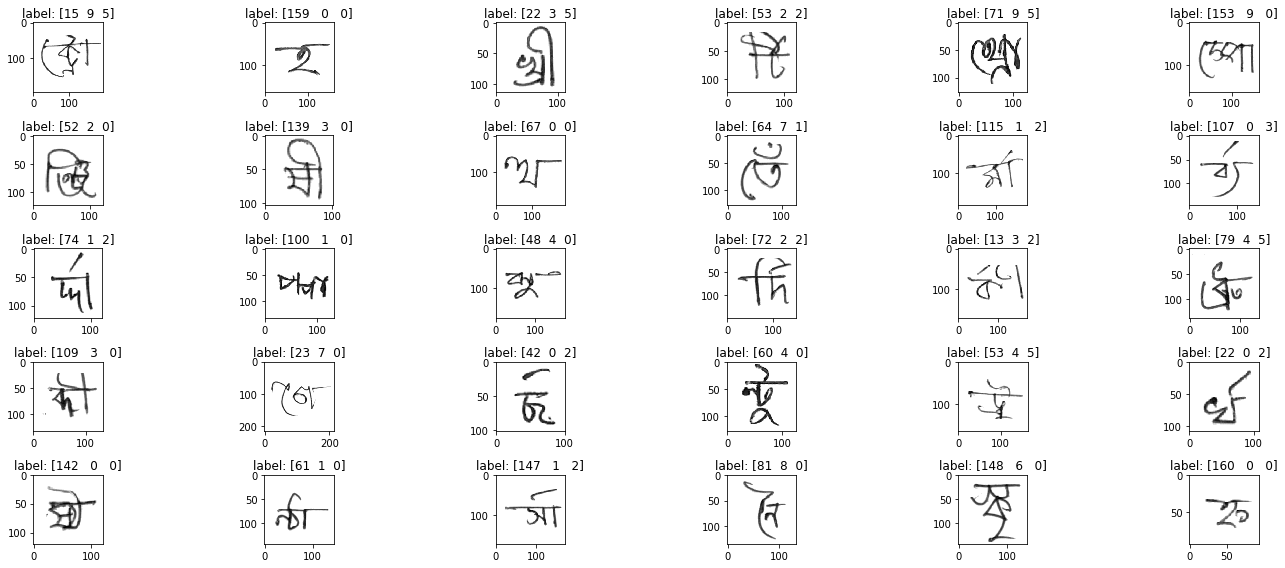

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

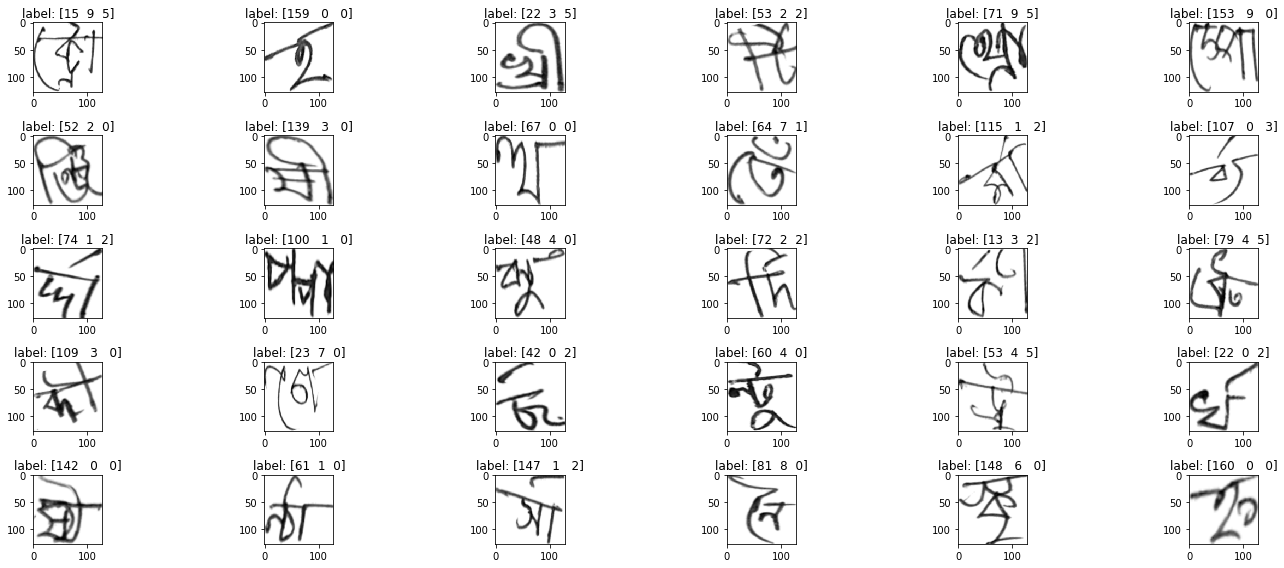

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

TH = 80.0

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [23]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

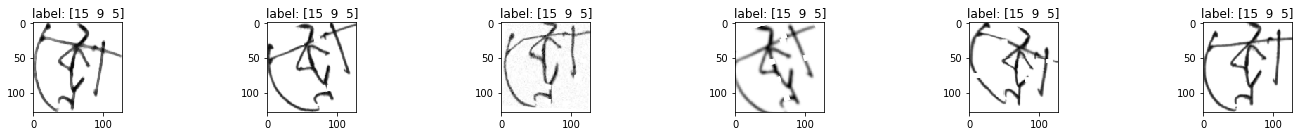

In [24]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

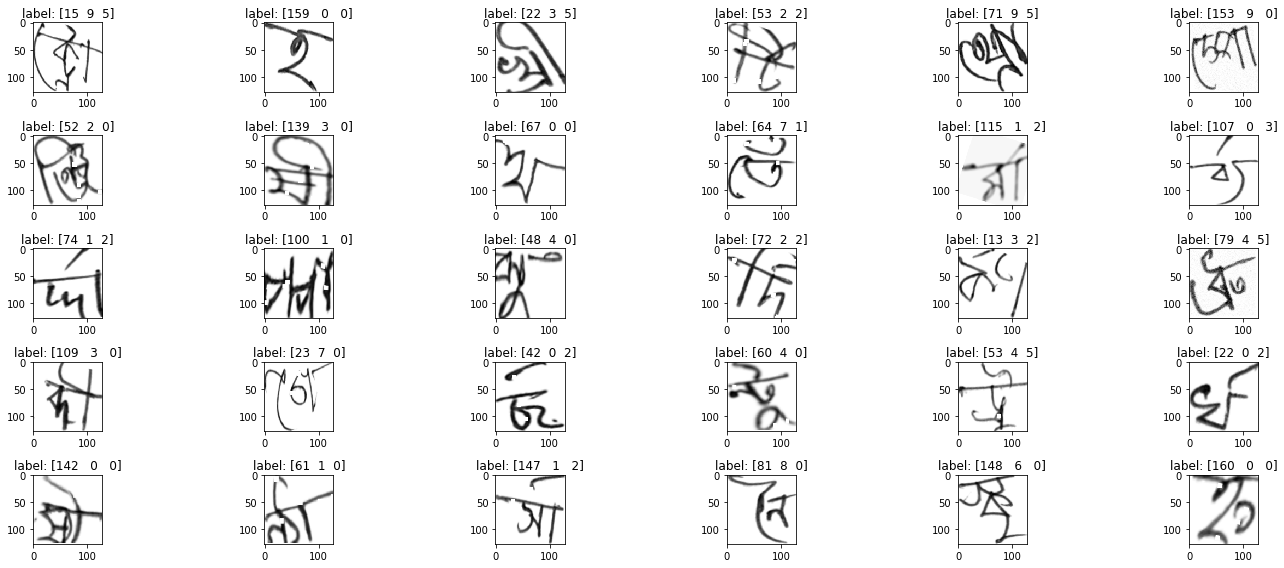

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [35]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [36]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [37]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [38]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [39]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [40]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [41]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [42]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [43]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [44]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [45]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [46]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [47]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 4
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=5, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /home/vemlr/.torch/models/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 110559176/110559176 [05:11<00:00, 355270.79it/s]


predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  5.828562 train/loss_grapheme  2.951875 train/loss_vowel  1.607501 train/loss_consonant  1.269186 train/acc_grapheme  0.500977 train/acc_vowel  0.766997 train/acc_consonant  0.869461 train/recall  0.541193 val/loss  3.512538 val/loss_grapheme  1.302077 val/loss_vowel  1.199375 val/loss_consonant  1.011086 val/acc_grapheme  0.870643 val/acc_vowel  0.970499 val/acc_consonant  0.973088 val/recall  0.865118 lr  0.000100 elapsed_time  622.273531 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  3.611444 train/loss_grapheme  1.628008 train/loss_vowel  1.085693 train/loss_consonant  0.897742 train/acc_grapheme  0.831228 train/acc_vowel  0.960130 train/acc_consonant  0.962445 train/recall  0.832639 val/loss  2.322621 val/loss_grapheme  0.730442 val/loss_vowel  0.857208 val/loss_consonant  0.734971 val/acc_grapheme  0.925513 val/acc_vowel  0.981453 val/acc_consonant  0.978789 val/recall  0.918842 lr  0.000100 elapsed_time  1250.377279 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  2.637112 train/loss_grapheme  1.174009 train/loss_vowel  0.795032 train/loss_consonant  0.668070 train/acc_grapheme  0.887261 train/acc_vowel  0.971009 train/acc_consonant  0.971775 train/recall  0.884900 val/loss  1.655186 val/loss_grapheme  0.487002 val/loss_vowel  0.628250 val/loss_consonant  0.539934 val/acc_grapheme  0.940674 val/acc_vowel  0.983694 val/acc_consonant  0.982648 val/recall  0.936413 lr  0.000100 elapsed_time  1872.905316 mode 011 


100%|██████████| 419/419 [01:06<00:00,  6.28it/s]


epoch      3 train/loss  1.963621 train/loss_grapheme  0.880058 train/loss_vowel  0.586299 train/loss_consonant  0.497265 train/acc_grapheme  0.910470 train/acc_vowel  0.975764 train/acc_consonant  0.976642 train/recall  0.907503 val/loss  1.205412 val/loss_grapheme  0.372368 val/loss_vowel  0.444713 val/loss_consonant  0.388331 val/acc_grapheme  0.946201 val/acc_vowel  0.985137 val/acc_consonant  0.984216 val/recall  0.941610 lr  0.000100 elapsed_time  2485.356560 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  1.496623 train/loss_grapheme  0.687497 train/loss_vowel  0.436382 train/loss_consonant  0.372744 train/acc_grapheme  0.923042 train/acc_vowel  0.978316 train/acc_consonant  0.979243 train/recall  0.920057 val/loss  0.954806 val/loss_grapheme  0.329013 val/loss_vowel  0.333842 val/loss_consonant  0.291951 val/acc_grapheme  0.948939 val/acc_vowel  0.985909 val/acc_consonant  0.984291 val/recall  0.947462 lr  0.000100 elapsed_time  3101.029927 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  1.159485 train/loss_grapheme  0.549834 train/loss_vowel  0.327631 train/loss_consonant  0.282020 train/acc_grapheme  0.932135 train/acc_vowel  0.980127 train/acc_consonant  0.980700 train/recall  0.929294 val/loss  0.762740 val/loss_grapheme  0.294515 val/loss_vowel  0.244164 val/loss_consonant  0.224061 val/acc_grapheme  0.949612 val/acc_vowel  0.986507 val/acc_consonant  0.984714 val/recall  0.947111 lr  0.000100 elapsed_time  3725.002363 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.925132 train/loss_grapheme  0.456428 train/loss_vowel  0.252452 train/loss_consonant  0.216252 train/acc_grapheme  0.938110 train/acc_vowel  0.981185 train/acc_consonant  0.982075 train/recall  0.935085 val/loss  0.624780 val/loss_grapheme  0.273401 val/loss_vowel  0.180203 val/loss_consonant  0.171176 val/acc_grapheme  0.950433 val/acc_vowel  0.986482 val/acc_consonant  0.984789 val/recall  0.947799 lr  0.000100 elapsed_time  4338.569756 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.752355 train/loss_grapheme  0.390368 train/loss_vowel  0.195251 train/loss_consonant  0.166736 train/acc_grapheme  0.942585 train/acc_vowel  0.983065 train/acc_consonant  0.983669 train/recall  0.940152 val/loss  0.558999 val/loss_grapheme  0.267698 val/loss_vowel  0.150707 val/loss_consonant  0.140593 val/acc_grapheme  0.953246 val/acc_vowel  0.987527 val/acc_consonant  0.985461 val/recall  0.950292 lr  0.000100 elapsed_time  4954.858711 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.632534 train/loss_grapheme  0.342703 train/loss_vowel  0.156886 train/loss_consonant  0.132945 train/acc_grapheme  0.946550 train/acc_vowel  0.984092 train/acc_consonant  0.984814 train/recall  0.944074 val/loss  0.487817 val/loss_grapheme  0.262851 val/loss_vowel  0.115481 val/loss_consonant  0.109484 val/acc_grapheme  0.952350 val/acc_vowel  0.987403 val/acc_consonant  0.986457 val/recall  0.950314 lr  0.000100 elapsed_time  5567.863253 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.540788 train/loss_grapheme  0.304173 train/loss_vowel  0.128353 train/loss_consonant  0.108262 train/acc_grapheme  0.949618 train/acc_vowel  0.984758 train/acc_consonant  0.985511 train/recall  0.946938 val/loss  0.435784 val/loss_grapheme  0.247715 val/loss_vowel  0.096166 val/loss_consonant  0.091903 val/acc_grapheme  0.955114 val/acc_vowel  0.987801 val/acc_consonant  0.986706 val/recall  0.953051 lr  0.000100 elapsed_time  6186.072731 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.474599 train/loss_grapheme  0.274346 train/loss_vowel  0.109362 train/loss_consonant  0.090891 train/acc_grapheme  0.953134 train/acc_vowel  0.985063 train/acc_consonant  0.986027 train/recall  0.950709 val/loss  0.402395 val/loss_grapheme  0.240007 val/loss_vowel  0.081797 val/loss_consonant  0.080591 val/acc_grapheme  0.957030 val/acc_vowel  0.988224 val/acc_consonant  0.986532 val/recall  0.954554 lr  0.000100 elapsed_time  6800.525865 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.420052 train/loss_grapheme  0.245491 train/loss_vowel  0.094846 train/loss_consonant  0.079716 train/acc_grapheme  0.955898 train/acc_vowel  0.985324 train/acc_consonant  0.986252 train/recall  0.953274 val/loss  0.382870 val/loss_grapheme  0.239815 val/loss_vowel  0.074204 val/loss_consonant  0.068852 val/acc_grapheme  0.955611 val/acc_vowel  0.988050 val/acc_consonant  0.987478 val/recall  0.953317 lr  0.000100 elapsed_time  7415.670275 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.381970 train/loss_grapheme  0.229117 train/loss_vowel  0.082130 train/loss_consonant  0.070724 train/acc_grapheme  0.957958 train/acc_vowel  0.986837 train/acc_consonant  0.986538 train/recall  0.955190 val/loss  0.368273 val/loss_grapheme  0.235488 val/loss_vowel  0.067153 val/loss_consonant  0.065632 val/acc_grapheme  0.955836 val/acc_vowel  0.988523 val/acc_consonant  0.987179 val/recall  0.954499 lr  0.000100 elapsed_time  8034.610279 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.348090 train/loss_grapheme  0.212397 train/loss_vowel  0.073653 train/loss_consonant  0.062039 train/acc_grapheme  0.959539 train/acc_vowel  0.986799 train/acc_consonant  0.987683 train/recall  0.956899 val/loss  0.371814 val/loss_grapheme  0.242038 val/loss_vowel  0.063394 val/loss_consonant  0.066382 val/acc_grapheme  0.955661 val/acc_vowel  0.987677 val/acc_consonant  0.985685 val/recall  0.953119 lr  0.000100 elapsed_time  8651.098972 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.327248 train/loss_grapheme  0.201435 train/loss_vowel  0.068424 train/loss_consonant  0.057390 train/acc_grapheme  0.960410 train/acc_vowel  0.987061 train/acc_consonant  0.987608 train/recall  0.957551 val/loss  0.351369 val/loss_grapheme  0.232276 val/loss_vowel  0.060051 val/loss_consonant  0.059042 val/acc_grapheme  0.958425 val/acc_vowel  0.988374 val/acc_consonant  0.986581 val/recall  0.955583 lr  0.000100 elapsed_time  9266.666477 mode 011 


100%|██████████| 419/419 [01:06<00:00,  6.27it/s]


epoch     15 train/loss  0.301491 train/loss_grapheme  0.186961 train/loss_vowel  0.061895 train/loss_consonant  0.052635 train/acc_grapheme  0.962564 train/acc_vowel  0.987926 train/acc_consonant  0.988386 train/recall  0.959674 val/loss  0.341929 val/loss_grapheme  0.226708 val/loss_vowel  0.057330 val/loss_consonant  0.057891 val/acc_grapheme  0.957404 val/acc_vowel  0.988498 val/acc_consonant  0.986631 val/recall  0.955522 lr  0.000100 elapsed_time  9880.221729 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.287318 train/loss_grapheme  0.179476 train/loss_vowel  0.057344 train/loss_consonant  0.050497 train/acc_grapheme  0.963522 train/acc_vowel  0.988349 train/acc_consonant  0.988280 train/recall  0.960729 val/loss  0.332249 val/loss_grapheme  0.224158 val/loss_vowel  0.054218 val/loss_consonant  0.053873 val/acc_grapheme  0.957055 val/acc_vowel  0.989320 val/acc_consonant  0.986955 val/recall  0.954437 lr  0.000100 elapsed_time  10496.996004 mode 010 


100%|██████████| 419/419 [01:06<00:00,  6.29it/s]


epoch     17 train/loss  0.272611 train/loss_grapheme  0.170159 train/loss_vowel  0.055088 train/loss_consonant  0.047363 train/acc_grapheme  0.964966 train/acc_vowel  0.988044 train/acc_consonant  0.988828 train/recall  0.962443 val/loss  0.333408 val/loss_grapheme  0.224763 val/loss_vowel  0.053091 val/loss_consonant  0.055554 val/acc_grapheme  0.956856 val/acc_vowel  0.988747 val/acc_consonant  0.986432 val/recall  0.955020 lr  0.000100 elapsed_time  11112.397109 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.260289 train/loss_grapheme  0.162077 train/loss_vowel  0.052430 train/loss_consonant  0.045782 train/acc_grapheme  0.965850 train/acc_vowel  0.988890 train/acc_consonant  0.989133 train/recall  0.963059 val/loss  0.324138 val/loss_grapheme  0.213645 val/loss_vowel  0.053564 val/loss_consonant  0.056929 val/acc_grapheme  0.958275 val/acc_vowel  0.988224 val/acc_consonant  0.986731 val/recall  0.956616 lr  0.000100 elapsed_time  11730.026981 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.246010 train/loss_grapheme  0.154438 train/loss_vowel  0.048434 train/loss_consonant  0.043138 train/acc_grapheme  0.967119 train/acc_vowel  0.989314 train/acc_consonant  0.989488 train/recall  0.964326 val/loss  0.332489 val/loss_grapheme  0.228818 val/loss_vowel  0.050863 val/loss_consonant  0.052808 val/acc_grapheme  0.956408 val/acc_vowel  0.989171 val/acc_consonant  0.987278 val/recall  0.954009 lr  0.000100 elapsed_time  12348.337986 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.238043 train/loss_grapheme  0.150342 train/loss_vowel  0.046142 train/loss_consonant  0.041559 train/acc_grapheme  0.967804 train/acc_vowel  0.989637 train/acc_consonant  0.989681 train/recall  0.964890 val/loss  0.326086 val/loss_grapheme  0.222507 val/loss_vowel  0.050379 val/loss_consonant  0.053200 val/acc_grapheme  0.955587 val/acc_vowel  0.988971 val/acc_consonant  0.986905 val/recall  0.954036 lr  0.000100 elapsed_time  12959.896235 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.226408 train/loss_grapheme  0.142666 train/loss_vowel  0.045262 train/loss_consonant  0.038479 train/acc_grapheme  0.968594 train/acc_vowel  0.989588 train/acc_consonant  0.990471 train/recall  0.966063 val/loss  0.330283 val/loss_grapheme  0.224115 val/loss_vowel  0.049602 val/loss_consonant  0.056566 val/acc_grapheme  0.957752 val/acc_vowel  0.989519 val/acc_consonant  0.986133 val/recall  0.955986 lr  0.000100 elapsed_time  13573.626577 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.222469 train/loss_grapheme  0.139033 train/loss_vowel  0.043964 train/loss_consonant  0.039472 train/acc_grapheme  0.969466 train/acc_vowel  0.989836 train/acc_consonant  0.989749 train/recall  0.967116 val/loss  0.341833 val/loss_grapheme  0.236324 val/loss_vowel  0.049535 val/loss_consonant  0.055974 val/acc_grapheme  0.953844 val/acc_vowel  0.988872 val/acc_consonant  0.986756 val/recall  0.952025 lr  0.000100 elapsed_time  14183.956828 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.27it/s]


epoch     23 train/loss  0.215587 train/loss_grapheme  0.134031 train/loss_vowel  0.043217 train/loss_consonant  0.038339 train/acc_grapheme  0.970387 train/acc_vowel  0.989544 train/acc_consonant  0.990017 train/recall  0.967780 val/loss  0.318768 val/loss_grapheme  0.212150 val/loss_vowel  0.052436 val/loss_consonant  0.054181 val/acc_grapheme  0.958001 val/acc_vowel  0.988324 val/acc_consonant  0.986233 val/recall  0.955343 lr  0.000100 elapsed_time  14794.450651 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.210028 train/loss_grapheme  0.130795 train/loss_vowel  0.042534 train/loss_consonant  0.036699 train/acc_grapheme  0.970430 train/acc_vowel  0.989762 train/acc_consonant  0.990471 train/recall  0.968099 val/loss  0.320293 val/loss_grapheme  0.215674 val/loss_vowel  0.051278 val/loss_consonant  0.053341 val/acc_grapheme  0.957902 val/acc_vowel  0.988722 val/acc_consonant  0.986656 val/recall  0.955632 lr  0.000100 elapsed_time  15411.396900 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.205610 train/loss_grapheme  0.128490 train/loss_vowel  0.040345 train/loss_consonant  0.036775 train/acc_grapheme  0.970698 train/acc_vowel  0.990490 train/acc_consonant  0.990328 train/recall  0.968112 val/loss  0.320607 val/loss_grapheme  0.217141 val/loss_vowel  0.051857 val/loss_consonant  0.051608 val/acc_grapheme  0.957304 val/acc_vowel  0.987751 val/acc_consonant  0.987527 val/recall  0.955401 lr  0.000100 elapsed_time  16024.857047 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.195991 train/loss_grapheme  0.121314 train/loss_vowel  0.038545 train/loss_consonant  0.036132 train/acc_grapheme  0.972746 train/acc_vowel  0.990534 train/acc_consonant  0.990005 train/recall  0.969810 val/loss  0.329332 val/loss_grapheme  0.226606 val/loss_vowel  0.049428 val/loss_consonant  0.053299 val/acc_grapheme  0.955885 val/acc_vowel  0.989220 val/acc_consonant  0.987054 val/recall  0.955052 lr  0.000100 elapsed_time  16636.766109 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.27it/s]


epoch     27 train/loss  0.193478 train/loss_grapheme  0.119704 train/loss_vowel  0.039248 train/loss_consonant  0.034527 train/acc_grapheme  0.972347 train/acc_vowel  0.990614 train/acc_consonant  0.990583 train/recall  0.970462 val/loss  0.314710 val/loss_grapheme  0.211965 val/loss_vowel  0.051075 val/loss_consonant  0.051670 val/acc_grapheme  0.957728 val/acc_vowel  0.988623 val/acc_consonant  0.986332 val/recall  0.954698 lr  0.000100 elapsed_time  17248.545601 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.187119 train/loss_grapheme  0.116256 train/loss_vowel  0.036586 train/loss_consonant  0.034277 train/acc_grapheme  0.973100 train/acc_vowel  0.991031 train/acc_consonant  0.990726 train/recall  0.970421 val/loss  0.327332 val/loss_grapheme  0.223754 val/loss_vowel  0.050275 val/loss_consonant  0.053302 val/acc_grapheme  0.954765 val/acc_vowel  0.988673 val/acc_consonant  0.986930 val/recall  0.953317 lr  0.000100 elapsed_time  17859.506813 mode 000 


100%|██████████| 419/419 [01:07<00:00,  6.25it/s]


epoch     29 train/loss  0.183695 train/loss_grapheme  0.113739 train/loss_vowel  0.036365 train/loss_consonant  0.033591 train/acc_grapheme  0.973412 train/acc_vowel  0.990982 train/acc_consonant  0.990820 train/recall  0.971007 val/loss  0.330387 val/loss_grapheme  0.226802 val/loss_vowel  0.049644 val/loss_consonant  0.053941 val/acc_grapheme  0.953769 val/acc_vowel  0.988922 val/acc_consonant  0.986880 val/recall  0.952588 lr  0.000100 elapsed_time  18472.611633 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.176448 train/loss_grapheme  0.108650 train/loss_vowel  0.036282 train/loss_consonant  0.031517 train/acc_grapheme  0.974420 train/acc_vowel  0.990870 train/acc_consonant  0.991424 train/recall  0.972087 val/loss  0.309871 val/loss_grapheme  0.207956 val/loss_vowel  0.049786 val/loss_consonant  0.052129 val/acc_grapheme  0.959396 val/acc_vowel  0.988996 val/acc_consonant  0.987005 val/recall  0.956754 lr  0.000100 elapsed_time  19086.690189 mode 011 


100%|██████████| 419/419 [01:06<00:00,  6.26it/s]


epoch     31 train/loss  0.174993 train/loss_grapheme  0.107800 train/loss_vowel  0.035383 train/loss_consonant  0.031809 train/acc_grapheme  0.974949 train/acc_vowel  0.991007 train/acc_consonant  0.991156 train/recall  0.972677 val/loss  0.304647 val/loss_grapheme  0.203408 val/loss_vowel  0.048244 val/loss_consonant  0.052995 val/acc_grapheme  0.958773 val/acc_vowel  0.988971 val/acc_consonant  0.987029 val/recall  0.956093 lr  0.000100 elapsed_time  19698.193096 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.170825 train/loss_grapheme  0.105232 train/loss_vowel  0.034598 train/loss_consonant  0.030995 train/acc_grapheme  0.975049 train/acc_vowel  0.991262 train/acc_consonant  0.991386 train/recall  0.972294 val/loss  0.313858 val/loss_grapheme  0.207363 val/loss_vowel  0.051211 val/loss_consonant  0.055283 val/acc_grapheme  0.959022 val/acc_vowel  0.988673 val/acc_consonant  0.986805 val/recall  0.956026 lr  0.000100 elapsed_time  20313.091545 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.167003 train/loss_grapheme  0.102229 train/loss_vowel  0.034324 train/loss_consonant  0.030449 train/acc_grapheme  0.975553 train/acc_vowel  0.991417 train/acc_consonant  0.991623 train/recall  0.973023 val/loss  0.333213 val/loss_grapheme  0.225427 val/loss_vowel  0.051399 val/loss_consonant  0.056387 val/acc_grapheme  0.956333 val/acc_vowel  0.988075 val/acc_consonant  0.986482 val/recall  0.953726 lr  0.000100 elapsed_time  20924.333445 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.162750 train/loss_grapheme  0.102101 train/loss_vowel  0.031276 train/loss_consonant  0.029373 train/acc_grapheme  0.975584 train/acc_vowel  0.992058 train/acc_consonant  0.991953 train/recall  0.973943 val/loss  0.317756 val/loss_grapheme  0.211420 val/loss_vowel  0.052463 val/loss_consonant  0.053873 val/acc_grapheme  0.957429 val/acc_vowel  0.988498 val/acc_consonant  0.987303 val/recall  0.955095 lr  0.000100 elapsed_time  21539.627427 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.28it/s]


epoch     35 train/loss  0.162110 train/loss_grapheme  0.099398 train/loss_vowel  0.032667 train/loss_consonant  0.030045 train/acc_grapheme  0.976125 train/acc_vowel  0.991654 train/acc_consonant  0.991859 train/recall  0.973733 val/loss  0.317386 val/loss_grapheme  0.216306 val/loss_vowel  0.048864 val/loss_consonant  0.052215 val/acc_grapheme  0.957553 val/acc_vowel  0.988648 val/acc_consonant  0.986855 val/recall  0.955514 lr  0.000100 elapsed_time  22153.516994 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.159736 train/loss_grapheme  0.097807 train/loss_vowel  0.033160 train/loss_consonant  0.028770 train/acc_grapheme  0.976387 train/acc_vowel  0.991486 train/acc_consonant  0.992071 train/recall  0.974017 val/loss  0.324877 val/loss_grapheme  0.221426 val/loss_vowel  0.049179 val/loss_consonant  0.054272 val/acc_grapheme  0.953645 val/acc_vowel  0.988697 val/acc_consonant  0.987029 val/recall  0.952299 lr  0.000100 elapsed_time  22768.486103 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.154376 train/loss_grapheme  0.095005 train/loss_vowel  0.030935 train/loss_consonant  0.028435 train/acc_grapheme  0.976947 train/acc_vowel  0.991915 train/acc_consonant  0.992096 train/recall  0.974389 val/loss  0.321462 val/loss_grapheme  0.218369 val/loss_vowel  0.049747 val/loss_consonant  0.053346 val/acc_grapheme  0.956831 val/acc_vowel  0.988224 val/acc_consonant  0.987154 val/recall  0.954978 lr  0.000100 elapsed_time  23381.413376 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.153407 train/loss_grapheme  0.094995 train/loss_vowel  0.030442 train/loss_consonant  0.027970 train/acc_grapheme  0.977190 train/acc_vowel  0.992083 train/acc_consonant  0.991921 train/recall  0.975061 val/loss  0.330625 val/loss_grapheme  0.218807 val/loss_vowel  0.054451 val/loss_consonant  0.057367 val/acc_grapheme  0.957105 val/acc_vowel  0.987751 val/acc_consonant  0.985810 val/recall  0.953466 lr  0.000100 elapsed_time  23991.622945 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.149698 train/loss_grapheme  0.090423 train/loss_vowel  0.032396 train/loss_consonant  0.026879 train/acc_grapheme  0.977887 train/acc_vowel  0.991654 train/acc_consonant  0.992500 train/recall  0.975806 val/loss  0.321737 val/loss_grapheme  0.214771 val/loss_vowel  0.052102 val/loss_consonant  0.054865 val/acc_grapheme  0.957603 val/acc_vowel  0.988424 val/acc_consonant  0.986108 val/recall  0.953913 lr  0.000100 elapsed_time  24604.147708 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.147007 train/loss_grapheme  0.089675 train/loss_vowel  0.029561 train/loss_consonant  0.027772 train/acc_grapheme  0.978571 train/acc_vowel  0.992276 train/acc_consonant  0.992208 train/recall  0.976148 val/loss  0.325484 val/loss_grapheme  0.217868 val/loss_vowel  0.052365 val/loss_consonant  0.055251 val/acc_grapheme  0.956109 val/acc_vowel  0.987876 val/acc_consonant  0.986606 val/recall  0.953958 lr  0.000100 elapsed_time  25219.821412 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.144187 train/loss_grapheme  0.088743 train/loss_vowel  0.028978 train/loss_consonant  0.026466 train/acc_grapheme  0.978422 train/acc_vowel  0.992538 train/acc_consonant  0.992320 train/recall  0.976288 val/loss  0.331399 val/loss_grapheme  0.225531 val/loss_vowel  0.050023 val/loss_consonant  0.055845 val/acc_grapheme  0.954865 val/acc_vowel  0.988847 val/acc_consonant  0.985934 val/recall  0.952530 lr  0.000100 elapsed_time  25834.320254 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.143455 train/loss_grapheme  0.088651 train/loss_vowel  0.028917 train/loss_consonant  0.025888 train/acc_grapheme  0.978104 train/acc_vowel  0.992307 train/acc_consonant  0.992718 train/recall  0.975760 val/loss  0.327395 val/loss_grapheme  0.221439 val/loss_vowel  0.050438 val/loss_consonant  0.055518 val/acc_grapheme  0.955537 val/acc_vowel  0.988598 val/acc_consonant  0.986133 val/recall  0.953329 lr  0.000100 elapsed_time  26445.645467 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.140769 train/loss_grapheme  0.085983 train/loss_vowel  0.029041 train/loss_consonant  0.025746 train/acc_grapheme  0.978851 train/acc_vowel  0.992581 train/acc_consonant  0.992569 train/recall  0.976564 val/loss  0.325595 val/loss_grapheme  0.220339 val/loss_vowel  0.050775 val/loss_consonant  0.054481 val/acc_grapheme  0.957230 val/acc_vowel  0.988996 val/acc_consonant  0.987527 val/recall  0.954808 lr  0.000100 elapsed_time  27060.582720 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.139308 train/loss_grapheme  0.085154 train/loss_vowel  0.028711 train/loss_consonant  0.025443 train/acc_grapheme  0.979007 train/acc_vowel  0.992500 train/acc_consonant  0.993054 train/recall  0.976790 val/loss  0.326675 val/loss_grapheme  0.221875 val/loss_vowel  0.050938 val/loss_consonant  0.053862 val/acc_grapheme  0.956607 val/acc_vowel  0.988498 val/acc_consonant  0.987254 val/recall  0.954362 lr  0.000100 elapsed_time  27675.499989 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.31it/s]


epoch     45 train/loss  0.136122 train/loss_grapheme  0.083057 train/loss_vowel  0.028223 train/loss_consonant  0.024841 train/acc_grapheme  0.979399 train/acc_vowel  0.992687 train/acc_consonant  0.992805 train/recall  0.977237 val/loss  0.325691 val/loss_grapheme  0.219346 val/loss_vowel  0.050992 val/loss_consonant  0.055352 val/acc_grapheme  0.956956 val/acc_vowel  0.989096 val/acc_consonant  0.986905 val/recall  0.955226 lr  0.000100 elapsed_time  28285.641299 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.132859 train/loss_grapheme  0.081831 train/loss_vowel  0.026552 train/loss_consonant  0.024476 train/acc_grapheme  0.980028 train/acc_vowel  0.992886 train/acc_consonant  0.993098 train/recall  0.977803 val/loss  0.322205 val/loss_grapheme  0.216552 val/loss_vowel  0.049679 val/loss_consonant  0.055975 val/acc_grapheme  0.957205 val/acc_vowel  0.988971 val/acc_consonant  0.986855 val/recall  0.954719 lr  0.000100 elapsed_time  28900.012259 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.133443 train/loss_grapheme  0.081415 train/loss_vowel  0.027366 train/loss_consonant  0.024662 train/acc_grapheme  0.979978 train/acc_vowel  0.992631 train/acc_consonant  0.992824 train/recall  0.977671 val/loss  0.336540 val/loss_grapheme  0.227815 val/loss_vowel  0.052679 val/loss_consonant  0.056045 val/acc_grapheme  0.955064 val/acc_vowel  0.987453 val/acc_consonant  0.986681 val/recall  0.952788 lr  0.000100 elapsed_time  29511.185030 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.133998 train/loss_grapheme  0.081805 train/loss_vowel  0.027430 train/loss_consonant  0.024763 train/acc_grapheme  0.979916 train/acc_vowel  0.992861 train/acc_consonant  0.992899 train/recall  0.977694 val/loss  0.320871 val/loss_grapheme  0.214586 val/loss_vowel  0.050173 val/loss_consonant  0.056111 val/acc_grapheme  0.956657 val/acc_vowel  0.989419 val/acc_consonant  0.986183 val/recall  0.954885 lr  0.000100 elapsed_time  30123.854804 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.128919 train/loss_grapheme  0.078871 train/loss_vowel  0.026692 train/loss_consonant  0.023356 train/acc_grapheme  0.980799 train/acc_vowel  0.992849 train/acc_consonant  0.993390 train/recall  0.978516 val/loss  0.323660 val/loss_grapheme  0.214885 val/loss_vowel  0.052702 val/loss_consonant  0.056072 val/acc_grapheme  0.956856 val/acc_vowel  0.988100 val/acc_consonant  0.986606 val/recall  0.954137 lr  0.000100 elapsed_time  30735.535231 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.131499 train/loss_grapheme  0.080555 train/loss_vowel  0.026861 train/loss_consonant  0.024083 train/acc_grapheme  0.980021 train/acc_vowel  0.992998 train/acc_consonant  0.993079 train/recall  0.977993 val/loss  0.338015 val/loss_grapheme  0.226818 val/loss_vowel  0.053909 val/loss_consonant  0.057288 val/acc_grapheme  0.954541 val/acc_vowel  0.988573 val/acc_consonant  0.987328 val/recall  0.952405 lr  0.000100 elapsed_time  31346.268502 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.129363 train/loss_grapheme  0.080278 train/loss_vowel  0.025485 train/loss_consonant  0.023601 train/acc_grapheme  0.980040 train/acc_vowel  0.993073 train/acc_consonant  0.993154 train/recall  0.978169 val/loss  0.325983 val/loss_grapheme  0.217913 val/loss_vowel  0.052599 val/loss_consonant  0.055471 val/acc_grapheme  0.957329 val/acc_vowel  0.988075 val/acc_consonant  0.987054 val/recall  0.955241 lr  0.000100 elapsed_time  31958.419753 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.122813 train/loss_grapheme  0.073865 train/loss_vowel  0.026176 train/loss_consonant  0.022772 train/acc_grapheme  0.981895 train/acc_vowel  0.993004 train/acc_consonant  0.993496 train/recall  0.980032 val/loss  0.335078 val/loss_grapheme  0.225230 val/loss_vowel  0.052140 val/loss_consonant  0.057708 val/acc_grapheme  0.953894 val/acc_vowel  0.988498 val/acc_consonant  0.985984 val/recall  0.951810 lr  0.000100 elapsed_time  32571.010082 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.124052 train/loss_grapheme  0.075725 train/loss_vowel  0.025516 train/loss_consonant  0.022811 train/acc_grapheme  0.981210 train/acc_vowel  0.993253 train/acc_consonant  0.993453 train/recall  0.979069 val/loss  0.323643 val/loss_grapheme  0.218009 val/loss_vowel  0.050626 val/loss_consonant  0.055008 val/acc_grapheme  0.955711 val/acc_vowel  0.988424 val/acc_consonant  0.986855 val/recall  0.951319 lr  0.000100 elapsed_time  33187.396198 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.26it/s]


epoch     54 train/loss  0.124788 train/loss_grapheme  0.076725 train/loss_vowel  0.025612 train/loss_consonant  0.022451 train/acc_grapheme  0.981185 train/acc_vowel  0.993092 train/acc_consonant  0.993726 train/recall  0.978939 val/loss  0.328852 val/loss_grapheme  0.221330 val/loss_vowel  0.052619 val/loss_consonant  0.054903 val/acc_grapheme  0.955387 val/acc_vowel  0.988125 val/acc_consonant  0.987154 val/recall  0.952878 lr  0.000100 elapsed_time  33799.333169 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.26it/s]


epoch     55 train/loss  0.122413 train/loss_grapheme  0.073989 train/loss_vowel  0.025148 train/loss_consonant  0.023277 train/acc_grapheme  0.981223 train/acc_vowel  0.993322 train/acc_consonant  0.993446 train/recall  0.979509 val/loss  0.342057 val/loss_grapheme  0.233644 val/loss_vowel  0.053081 val/loss_consonant  0.055332 val/acc_grapheme  0.954416 val/acc_vowel  0.988249 val/acc_consonant  0.986930 val/recall  0.951313 lr  0.000100 elapsed_time  34413.111825 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.120729 train/loss_grapheme  0.074414 train/loss_vowel  0.024377 train/loss_consonant  0.021938 train/acc_grapheme  0.981428 train/acc_vowel  0.993645 train/acc_consonant  0.993652 train/recall  0.979395 val/loss  0.339579 val/loss_grapheme  0.226607 val/loss_vowel  0.054571 val/loss_consonant  0.058400 val/acc_grapheme  0.956159 val/acc_vowel  0.988025 val/acc_consonant  0.986158 val/recall  0.953784 lr  0.000100 elapsed_time  35027.298775 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.120959 train/loss_grapheme  0.071298 train/loss_vowel  0.026900 train/loss_consonant  0.022761 train/acc_grapheme  0.982131 train/acc_vowel  0.992917 train/acc_consonant  0.993390 train/recall  0.979766 val/loss  0.337593 val/loss_grapheme  0.230547 val/loss_vowel  0.050636 val/loss_consonant  0.056411 val/acc_grapheme  0.956408 val/acc_vowel  0.988747 val/acc_consonant  0.986407 val/recall  0.952992 lr  0.000100 elapsed_time  35640.937774 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.117517 train/loss_grapheme  0.072022 train/loss_vowel  0.023490 train/loss_consonant  0.022005 train/acc_grapheme  0.982256 train/acc_vowel  0.993683 train/acc_consonant  0.993863 train/recall  0.980512 val/loss  0.342754 val/loss_grapheme  0.227130 val/loss_vowel  0.055580 val/loss_consonant  0.060044 val/acc_grapheme  0.956856 val/acc_vowel  0.987751 val/acc_consonant  0.986158 val/recall  0.952865 lr  0.000100 elapsed_time  36253.408768 mode 000 


100%|██████████| 419/419 [01:05<00:00,  6.38it/s]


epoch     59 train/loss  0.116666 train/loss_grapheme  0.070683 train/loss_vowel  0.023598 train/loss_consonant  0.022385 train/acc_grapheme  0.982194 train/acc_vowel  0.993670 train/acc_consonant  0.993521 train/recall  0.980310 val/loss  0.340044 val/loss_grapheme  0.219202 val/loss_vowel  0.056942 val/loss_consonant  0.063899 val/acc_grapheme  0.956508 val/acc_vowel  0.987577 val/acc_consonant  0.984839 val/recall  0.952927 lr  0.000100 elapsed_time  36862.050326 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.113501 train/loss_grapheme  0.067557 train/loss_vowel  0.024391 train/loss_consonant  0.021553 train/acc_grapheme  0.982797 train/acc_vowel  0.993378 train/acc_consonant  0.993602 train/recall  0.980677 val/loss  0.328117 val/loss_grapheme  0.218232 val/loss_vowel  0.051138 val/loss_consonant  0.058746 val/acc_grapheme  0.957230 val/acc_vowel  0.988971 val/acc_consonant  0.986681 val/recall  0.954708 lr  0.000100 elapsed_time  37473.571962 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.113269 train/loss_grapheme  0.069043 train/loss_vowel  0.022868 train/loss_consonant  0.021358 train/acc_grapheme  0.982592 train/acc_vowel  0.993795 train/acc_consonant  0.993882 train/recall  0.981048 val/loss  0.339715 val/loss_grapheme  0.227602 val/loss_vowel  0.053118 val/loss_consonant  0.058996 val/acc_grapheme  0.954392 val/acc_vowel  0.988523 val/acc_consonant  0.986283 val/recall  0.952417 lr  0.000100 elapsed_time  38087.854498 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.112776 train/loss_grapheme  0.068420 train/loss_vowel  0.023305 train/loss_consonant  0.021050 train/acc_grapheme  0.982729 train/acc_vowel  0.993770 train/acc_consonant  0.993870 train/recall  0.980880 val/loss  0.340446 val/loss_grapheme  0.228711 val/loss_vowel  0.051686 val/loss_consonant  0.060048 val/acc_grapheme  0.956284 val/acc_vowel  0.988897 val/acc_consonant  0.985909 val/recall  0.954852 lr  0.000100 elapsed_time  38704.042075 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.115472 train/loss_grapheme  0.070109 train/loss_vowel  0.023844 train/loss_consonant  0.021519 train/acc_grapheme  0.982337 train/acc_vowel  0.993490 train/acc_consonant  0.993932 train/recall  0.980792 val/loss  0.333090 val/loss_grapheme  0.219629 val/loss_vowel  0.054754 val/loss_consonant  0.058707 val/acc_grapheme  0.956931 val/acc_vowel  0.988897 val/acc_consonant  0.986059 val/recall  0.954214 lr  0.000100 elapsed_time  39313.686245 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.111510 train/loss_grapheme  0.067485 train/loss_vowel  0.023380 train/loss_consonant  0.020645 train/acc_grapheme  0.983239 train/acc_vowel  0.993565 train/acc_consonant  0.994125 train/recall  0.981155 val/loss  0.332877 val/loss_grapheme  0.221427 val/loss_vowel  0.055238 val/loss_consonant  0.056212 val/acc_grapheme  0.954242 val/acc_vowel  0.988299 val/acc_consonant  0.987104 val/recall  0.952198 lr  0.000100 elapsed_time  39926.039764 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.112386 train/loss_grapheme  0.067425 train/loss_vowel  0.023397 train/loss_consonant  0.021563 train/acc_grapheme  0.983581 train/acc_vowel  0.993807 train/acc_consonant  0.993907 train/recall  0.981372 val/loss  0.337545 val/loss_grapheme  0.227626 val/loss_vowel  0.054134 val/loss_consonant  0.055784 val/acc_grapheme  0.955487 val/acc_vowel  0.988722 val/acc_consonant  0.986631 val/recall  0.953616 lr  0.000100 elapsed_time  40539.397040 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.112213 train/loss_grapheme  0.068106 train/loss_vowel  0.023015 train/loss_consonant  0.021092 train/acc_grapheme  0.982797 train/acc_vowel  0.993870 train/acc_consonant  0.993963 train/recall  0.980569 val/loss  0.329327 val/loss_grapheme  0.218425 val/loss_vowel  0.054216 val/loss_consonant  0.056687 val/acc_grapheme  0.958076 val/acc_vowel  0.988274 val/acc_consonant  0.987129 val/recall  0.954969 lr  0.000100 elapsed_time  41155.222783 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.109878 train/loss_grapheme  0.065954 train/loss_vowel  0.022841 train/loss_consonant  0.021084 train/acc_grapheme  0.983594 train/acc_vowel  0.993714 train/acc_consonant  0.993938 train/recall  0.981257 val/loss  0.343628 val/loss_grapheme  0.230204 val/loss_vowel  0.055502 val/loss_consonant  0.057922 val/acc_grapheme  0.957329 val/acc_vowel  0.987801 val/acc_consonant  0.986930 val/recall  0.953477 lr  0.000100 elapsed_time  41772.376128 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.106918 train/loss_grapheme  0.064487 train/loss_vowel  0.022471 train/loss_consonant  0.019960 train/acc_grapheme  0.983407 train/acc_vowel  0.994000 train/acc_consonant  0.994224 train/recall  0.981717 val/loss  0.334978 val/loss_grapheme  0.224577 val/loss_vowel  0.052196 val/loss_consonant  0.058204 val/acc_grapheme  0.956881 val/acc_vowel  0.988673 val/acc_consonant  0.986233 val/recall  0.954487 lr  0.000100 elapsed_time  42381.657454 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.110196 train/loss_grapheme  0.066189 train/loss_vowel  0.023038 train/loss_consonant  0.020969 train/acc_grapheme  0.983494 train/acc_vowel  0.993969 train/acc_consonant  0.993919 train/recall  0.981380 val/loss  0.329362 val/loss_grapheme  0.218462 val/loss_vowel  0.054622 val/loss_consonant  0.056279 val/acc_grapheme  0.956806 val/acc_vowel  0.988175 val/acc_consonant  0.986830 val/recall  0.953992 lr  0.000100 elapsed_time  42996.592733 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.106946 train/loss_grapheme  0.064814 train/loss_vowel  0.022709 train/loss_consonant  0.019423 train/acc_grapheme  0.983532 train/acc_vowel  0.993870 train/acc_consonant  0.994392 train/recall  0.981828 val/loss  0.335779 val/loss_grapheme  0.224917 val/loss_vowel  0.052782 val/loss_consonant  0.058080 val/acc_grapheme  0.956881 val/acc_vowel  0.988299 val/acc_consonant  0.987204 val/recall  0.954004 lr  0.000100 elapsed_time  43612.110032 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.105241 train/loss_grapheme  0.064127 train/loss_vowel  0.021983 train/loss_consonant  0.019131 train/acc_grapheme  0.984142 train/acc_vowel  0.994156 train/acc_consonant  0.994492 train/recall  0.982565 val/loss  0.334540 val/loss_grapheme  0.222657 val/loss_vowel  0.053887 val/loss_consonant  0.057996 val/acc_grapheme  0.957055 val/acc_vowel  0.988648 val/acc_consonant  0.986905 val/recall  0.954748 lr  0.000100 elapsed_time  44226.927120 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.105719 train/loss_grapheme  0.063455 train/loss_vowel  0.022776 train/loss_consonant  0.019488 train/acc_grapheme  0.984135 train/acc_vowel  0.993720 train/acc_consonant  0.994529 train/recall  0.982017 val/loss  0.325151 val/loss_grapheme  0.217991 val/loss_vowel  0.052835 val/loss_consonant  0.054325 val/acc_grapheme  0.957628 val/acc_vowel  0.988897 val/acc_consonant  0.987677 val/recall  0.955248 lr  0.000100 elapsed_time  44837.749512 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.107438 train/loss_grapheme  0.065743 train/loss_vowel  0.021110 train/loss_consonant  0.020585 train/acc_grapheme  0.983637 train/acc_vowel  0.994274 train/acc_consonant  0.994168 train/recall  0.981856 val/loss  0.332133 val/loss_grapheme  0.219335 val/loss_vowel  0.053854 val/loss_consonant  0.058943 val/acc_grapheme  0.957902 val/acc_vowel  0.988697 val/acc_consonant  0.985909 val/recall  0.954362 lr  0.000100 elapsed_time  45449.585047 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.105810 train/loss_grapheme  0.062942 train/loss_vowel  0.022574 train/loss_consonant  0.020295 train/acc_grapheme  0.983824 train/acc_vowel  0.993820 train/acc_consonant  0.993969 train/recall  0.981819 val/loss  0.329067 val/loss_grapheme  0.220332 val/loss_vowel  0.052357 val/loss_consonant  0.056378 val/acc_grapheme  0.957080 val/acc_vowel  0.988897 val/acc_consonant  0.986631 val/recall  0.955105 lr  0.000100 elapsed_time  46065.149768 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.104431 train/loss_grapheme  0.063682 train/loss_vowel  0.021205 train/loss_consonant  0.019544 train/acc_grapheme  0.983905 train/acc_vowel  0.994125 train/acc_consonant  0.994598 train/recall  0.982714 val/loss  0.337111 val/loss_grapheme  0.223512 val/loss_vowel  0.055495 val/loss_consonant  0.058104 val/acc_grapheme  0.956607 val/acc_vowel  0.989071 val/acc_consonant  0.986656 val/recall  0.954838 lr  0.000100 elapsed_time  46680.036147 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.103534 train/loss_grapheme  0.062072 train/loss_vowel  0.022013 train/loss_consonant  0.019449 train/acc_grapheme  0.984745 train/acc_vowel  0.994150 train/acc_consonant  0.994417 train/recall  0.982858 val/loss  0.334898 val/loss_grapheme  0.225157 val/loss_vowel  0.053028 val/loss_consonant  0.056714 val/acc_grapheme  0.955064 val/acc_vowel  0.988847 val/acc_consonant  0.986482 val/recall  0.952445 lr  0.000100 elapsed_time  47294.895151 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.102476 train/loss_grapheme  0.061493 train/loss_vowel  0.021034 train/loss_consonant  0.019949 train/acc_grapheme  0.984801 train/acc_vowel  0.994218 train/acc_consonant  0.994268 train/recall  0.983445 val/loss  0.343687 val/loss_grapheme  0.230304 val/loss_vowel  0.054705 val/loss_consonant  0.058678 val/acc_grapheme  0.955213 val/acc_vowel  0.987378 val/acc_consonant  0.987478 val/recall  0.953231 lr  0.000100 elapsed_time  47909.579058 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.101724 train/loss_grapheme  0.061572 train/loss_vowel  0.021245 train/loss_consonant  0.018906 train/acc_grapheme  0.984129 train/acc_vowel  0.994174 train/acc_consonant  0.994430 train/recall  0.982304 val/loss  0.330600 val/loss_grapheme  0.220279 val/loss_vowel  0.052762 val/loss_consonant  0.057560 val/acc_grapheme  0.956508 val/acc_vowel  0.988449 val/acc_consonant  0.987029 val/recall  0.952700 lr  0.000100 elapsed_time  48524.088803 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.100406 train/loss_grapheme  0.061374 train/loss_vowel  0.020448 train/loss_consonant  0.018585 train/acc_grapheme  0.984478 train/acc_vowel  0.994455 train/acc_consonant  0.994473 train/recall  0.982766 val/loss  0.335384 val/loss_grapheme  0.225257 val/loss_vowel  0.054320 val/loss_consonant  0.055806 val/acc_grapheme  0.957255 val/acc_vowel  0.988946 val/acc_consonant  0.987602 val/recall  0.953909 lr  0.000100 elapsed_time  49140.300829 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.101522 train/loss_grapheme  0.061345 train/loss_vowel  0.020854 train/loss_consonant  0.019323 train/acc_grapheme  0.984123 train/acc_vowel  0.994399 train/acc_consonant  0.994386 train/recall  0.982336 val/loss  0.350392 val/loss_grapheme  0.230964 val/loss_vowel  0.057235 val/loss_consonant  0.062193 val/acc_grapheme  0.955736 val/acc_vowel  0.987503 val/acc_consonant  0.986133 val/recall  0.953561 lr  0.000100 elapsed_time  49756.110500 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.101465 train/loss_grapheme  0.060466 train/loss_vowel  0.021014 train/loss_consonant  0.019985 train/acc_grapheme  0.984951 train/acc_vowel  0.994293 train/acc_consonant  0.994218 train/recall  0.983065 val/loss  0.353500 val/loss_grapheme  0.243661 val/loss_vowel  0.056286 val/loss_consonant  0.053553 val/acc_grapheme  0.954840 val/acc_vowel  0.988274 val/acc_consonant  0.987951 val/recall  0.952767 lr  0.000100 elapsed_time  50370.363137 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.098955 train/loss_grapheme  0.060972 train/loss_vowel  0.020022 train/loss_consonant  0.017961 train/acc_grapheme  0.984608 train/acc_vowel  0.994735 train/acc_consonant  0.994735 train/recall  0.983158 val/loss  0.344319 val/loss_grapheme  0.232046 val/loss_vowel  0.053922 val/loss_consonant  0.058351 val/acc_grapheme  0.957205 val/acc_vowel  0.988772 val/acc_consonant  0.987254 val/recall  0.955134 lr  0.000100 elapsed_time  50982.638018 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.099467 train/loss_grapheme  0.058850 train/loss_vowel  0.021689 train/loss_consonant  0.018927 train/acc_grapheme  0.985069 train/acc_vowel  0.994081 train/acc_consonant  0.994486 train/recall  0.983092 val/loss  0.341973 val/loss_grapheme  0.231256 val/loss_vowel  0.051906 val/loss_consonant  0.058812 val/acc_grapheme  0.956234 val/acc_vowel  0.988971 val/acc_consonant  0.987378 val/recall  0.953958 lr  0.000100 elapsed_time  51594.420491 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.100509 train/loss_grapheme  0.060679 train/loss_vowel  0.020380 train/loss_consonant  0.019450 train/acc_grapheme  0.984509 train/acc_vowel  0.994324 train/acc_consonant  0.994498 train/recall  0.982894 val/loss  0.335854 val/loss_grapheme  0.220006 val/loss_vowel  0.054488 val/loss_consonant  0.061361 val/acc_grapheme  0.956184 val/acc_vowel  0.988648 val/acc_consonant  0.985959 val/recall  0.952406 lr  0.000100 elapsed_time  52203.196103 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.096552 train/loss_grapheme  0.058374 train/loss_vowel  0.019800 train/loss_consonant  0.018378 train/acc_grapheme  0.985318 train/acc_vowel  0.994816 train/acc_consonant  0.994834 train/recall  0.983869 val/loss  0.344502 val/loss_grapheme  0.228923 val/loss_vowel  0.054023 val/loss_consonant  0.061556 val/acc_grapheme  0.955387 val/acc_vowel  0.988971 val/acc_consonant  0.985810 val/recall  0.953174 lr  0.000100 elapsed_time  52815.520274 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.100138 train/loss_grapheme  0.059624 train/loss_vowel  0.020939 train/loss_consonant  0.019575 train/acc_grapheme  0.984876 train/acc_vowel  0.994311 train/acc_consonant  0.994405 train/recall  0.983335 val/loss  0.334641 val/loss_grapheme  0.223904 val/loss_vowel  0.054774 val/loss_consonant  0.055963 val/acc_grapheme  0.957255 val/acc_vowel  0.988623 val/acc_consonant  0.987652 val/recall  0.954862 lr  0.000100 elapsed_time  53432.325563 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.097952 train/loss_grapheme  0.057804 train/loss_vowel  0.021449 train/loss_consonant  0.018700 train/acc_grapheme  0.985461 train/acc_vowel  0.994050 train/acc_consonant  0.994666 train/recall  0.983488 val/loss  0.342489 val/loss_grapheme  0.229275 val/loss_vowel  0.055696 val/loss_consonant  0.057519 val/acc_grapheme  0.955910 val/acc_vowel  0.988100 val/acc_consonant  0.986980 val/recall  0.952704 lr  0.000100 elapsed_time  54049.516825 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.097291 train/loss_grapheme  0.058755 train/loss_vowel  0.020548 train/loss_consonant  0.017988 train/acc_grapheme  0.985156 train/acc_vowel  0.994280 train/acc_consonant  0.994766 train/recall  0.983539 val/loss  0.349020 val/loss_grapheme  0.229955 val/loss_vowel  0.056887 val/loss_consonant  0.062179 val/acc_grapheme  0.955985 val/acc_vowel  0.988623 val/acc_consonant  0.986382 val/recall  0.953522 lr  0.000100 elapsed_time  54663.643656 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.095594 train/loss_grapheme  0.057169 train/loss_vowel  0.020699 train/loss_consonant  0.017726 train/acc_grapheme  0.985710 train/acc_vowel  0.994330 train/acc_consonant  0.994934 train/recall  0.983821 val/loss  0.341355 val/loss_grapheme  0.225354 val/loss_vowel  0.054461 val/loss_consonant  0.061540 val/acc_grapheme  0.956956 val/acc_vowel  0.989146 val/acc_consonant  0.986581 val/recall  0.954648 lr  0.000100 elapsed_time  55279.158978 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.097925 train/loss_grapheme  0.058195 train/loss_vowel  0.021160 train/loss_consonant  0.018570 train/acc_grapheme  0.985212 train/acc_vowel  0.994293 train/acc_consonant  0.994629 train/recall  0.982989 val/loss  0.330927 val/loss_grapheme  0.223101 val/loss_vowel  0.051801 val/loss_consonant  0.056025 val/acc_grapheme  0.957354 val/acc_vowel  0.988897 val/acc_consonant  0.987303 val/recall  0.956451 lr  0.000100 elapsed_time  55890.148454 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.092613 train/loss_grapheme  0.054792 train/loss_vowel  0.019751 train/loss_consonant  0.018070 train/acc_grapheme  0.986171 train/acc_vowel  0.994753 train/acc_consonant  0.994828 train/recall  0.984658 val/loss  0.335315 val/loss_grapheme  0.223677 val/loss_vowel  0.053286 val/loss_consonant  0.058351 val/acc_grapheme  0.956284 val/acc_vowel  0.988747 val/acc_consonant  0.987254 val/recall  0.953908 lr  0.000100 elapsed_time  56503.402719 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  0.096065 train/loss_grapheme  0.057572 train/loss_vowel  0.020651 train/loss_consonant  0.017842 train/acc_grapheme  0.985766 train/acc_vowel  0.994405 train/acc_consonant  0.994984 train/recall  0.984201 val/loss  0.345975 val/loss_grapheme  0.231596 val/loss_vowel  0.055501 val/loss_consonant  0.058878 val/acc_grapheme  0.956682 val/acc_vowel  0.988299 val/acc_consonant  0.987527 val/recall  0.955072 lr  0.000100 elapsed_time  57124.478979 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.095492 train/loss_grapheme  0.057319 train/loss_vowel  0.019915 train/loss_consonant  0.018257 train/acc_grapheme  0.985567 train/acc_vowel  0.994635 train/acc_consonant  0.994946 train/recall  0.983845 val/loss  0.340462 val/loss_grapheme  0.227417 val/loss_vowel  0.056903 val/loss_consonant  0.056142 val/acc_grapheme  0.956931 val/acc_vowel  0.987627 val/acc_consonant  0.987079 val/recall  0.953791 lr  0.000100 elapsed_time  57738.448635 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.093995 train/loss_grapheme  0.056965 train/loss_vowel  0.019300 train/loss_consonant  0.017730 train/acc_grapheme  0.985586 train/acc_vowel  0.994697 train/acc_consonant  0.994903 train/recall  0.984089 val/loss  0.337682 val/loss_grapheme  0.229683 val/loss_vowel  0.054093 val/loss_consonant  0.053905 val/acc_grapheme  0.956557 val/acc_vowel  0.989046 val/acc_consonant  0.987727 val/recall  0.953979 lr  0.000100 elapsed_time  58354.116288 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.094575 train/loss_grapheme  0.056701 train/loss_vowel  0.019719 train/loss_consonant  0.018156 train/acc_grapheme  0.985567 train/acc_vowel  0.994660 train/acc_consonant  0.994753 train/recall  0.983950 val/loss  0.339998 val/loss_grapheme  0.226149 val/loss_vowel  0.055246 val/loss_consonant  0.058604 val/acc_grapheme  0.957528 val/acc_vowel  0.988598 val/acc_consonant  0.986681 val/recall  0.954643 lr  0.000100 elapsed_time  58969.240790 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.094875 train/loss_grapheme  0.056931 train/loss_vowel  0.019502 train/loss_consonant  0.018443 train/acc_grapheme  0.985841 train/acc_vowel  0.994660 train/acc_consonant  0.994498 train/recall  0.984008 val/loss  0.347623 val/loss_grapheme  0.233375 val/loss_vowel  0.055731 val/loss_consonant  0.058517 val/acc_grapheme  0.955313 val/acc_vowel  0.987976 val/acc_consonant  0.986407 val/recall  0.953529 lr  0.000100 elapsed_time  59580.195239 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.091813 train/loss_grapheme  0.055546 train/loss_vowel  0.019752 train/loss_consonant  0.016515 train/acc_grapheme  0.985965 train/acc_vowel  0.994486 train/acc_consonant  0.995208 train/recall  0.984412 val/loss  0.344990 val/loss_grapheme  0.229027 val/loss_vowel  0.057074 val/loss_consonant  0.058890 val/acc_grapheme  0.955985 val/acc_vowel  0.987428 val/acc_consonant  0.986332 val/recall  0.953437 lr  0.000100 elapsed_time  60194.352522 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.096197 train/loss_grapheme  0.057409 train/loss_vowel  0.020349 train/loss_consonant  0.018439 train/acc_grapheme  0.985598 train/acc_vowel  0.994511 train/acc_consonant  0.994803 train/recall  0.984351 val/loss  0.337932 val/loss_grapheme  0.224416 val/loss_vowel  0.053566 val/loss_consonant  0.059950 val/acc_grapheme  0.957479 val/acc_vowel  0.989146 val/acc_consonant  0.986756 val/recall  0.955219 lr  0.000100 elapsed_time  60806.034674 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.091185 train/loss_grapheme  0.055083 train/loss_vowel  0.019460 train/loss_consonant  0.016642 train/acc_grapheme  0.985965 train/acc_vowel  0.994585 train/acc_consonant  0.995257 train/recall  0.984588 val/loss  0.348597 val/loss_grapheme  0.231054 val/loss_vowel  0.056163 val/loss_consonant  0.061380 val/acc_grapheme  0.955761 val/acc_vowel  0.988274 val/acc_consonant  0.986357 val/recall  0.953203 lr  0.000100 elapsed_time  61415.209764 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.091895 train/loss_grapheme  0.054145 train/loss_vowel  0.020059 train/loss_consonant  0.017691 train/acc_grapheme  0.986569 train/acc_vowel  0.994654 train/acc_consonant  0.994865 train/recall  0.985087 val/loss  0.332963 val/loss_grapheme  0.222560 val/loss_vowel  0.052182 val/loss_consonant  0.058221 val/acc_grapheme  0.958997 val/acc_vowel  0.988747 val/acc_consonant  0.986731 val/recall  0.955690 lr  0.000100 elapsed_time  62025.735080 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.091950 train/loss_grapheme  0.054793 train/loss_vowel  0.019335 train/loss_consonant  0.017821 train/acc_grapheme  0.986021 train/acc_vowel  0.994728 train/acc_consonant  0.994722 train/recall  0.984539 val/loss  0.350158 val/loss_grapheme  0.231961 val/loss_vowel  0.056459 val/loss_consonant  0.061737 val/acc_grapheme  0.957479 val/acc_vowel  0.988299 val/acc_consonant  0.986258 val/recall  0.954406 lr  0.000100 elapsed_time  62634.958441 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.090770 train/loss_grapheme  0.054045 train/loss_vowel  0.019061 train/loss_consonant  0.017664 train/acc_grapheme  0.986270 train/acc_vowel  0.994741 train/acc_consonant  0.994884 train/recall  0.984848 val/loss  0.333855 val/loss_grapheme  0.220645 val/loss_vowel  0.053811 val/loss_consonant  0.059399 val/acc_grapheme  0.957479 val/acc_vowel  0.988349 val/acc_consonant  0.986855 val/recall  0.954877 lr  0.000100 elapsed_time  63245.734079 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  0.093279 train/loss_grapheme  0.055438 train/loss_vowel  0.019794 train/loss_consonant  0.018048 train/acc_grapheme  0.986102 train/acc_vowel  0.994679 train/acc_consonant  0.994716 train/recall  0.984692 val/loss  0.355908 val/loss_grapheme  0.239353 val/loss_vowel  0.058434 val/loss_consonant  0.058121 val/acc_grapheme  0.955885 val/acc_vowel  0.987851 val/acc_consonant  0.987677 val/recall  0.953137 lr  0.000100 elapsed_time  63857.585823 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.089498 train/loss_grapheme  0.053215 train/loss_vowel  0.019566 train/loss_consonant  0.016716 train/acc_grapheme  0.986874 train/acc_vowel  0.994921 train/acc_consonant  0.995158 train/recall  0.985795 val/loss  0.334730 val/loss_grapheme  0.223040 val/loss_vowel  0.052855 val/loss_consonant  0.058835 val/acc_grapheme  0.958972 val/acc_vowel  0.989320 val/acc_consonant  0.986581 val/recall  0.955434 lr  0.000100 elapsed_time  64468.821590 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.086893 train/loss_grapheme  0.051696 train/loss_vowel  0.018104 train/loss_consonant  0.017093 train/acc_grapheme  0.986936 train/acc_vowel  0.995040 train/acc_consonant  0.995133 train/recall  0.985280 val/loss  0.354055 val/loss_grapheme  0.240645 val/loss_vowel  0.055759 val/loss_consonant  0.057651 val/acc_grapheme  0.956956 val/acc_vowel  0.988449 val/acc_consonant  0.987104 val/recall  0.954007 lr  0.000100 elapsed_time  65078.304943 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.091378 train/loss_grapheme  0.054934 train/loss_vowel  0.019712 train/loss_consonant  0.016732 train/acc_grapheme  0.986065 train/acc_vowel  0.994635 train/acc_consonant  0.995121 train/recall  0.984833 val/loss  0.335188 val/loss_grapheme  0.224594 val/loss_vowel  0.053264 val/loss_consonant  0.057330 val/acc_grapheme  0.957653 val/acc_vowel  0.989195 val/acc_consonant  0.987378 val/recall  0.955531 lr  0.000100 elapsed_time  65687.756416 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.087843 train/loss_grapheme  0.051258 train/loss_vowel  0.019245 train/loss_consonant  0.017340 train/acc_grapheme  0.987247 train/acc_vowel  0.994828 train/acc_consonant  0.995114 train/recall  0.985660 val/loss  0.338864 val/loss_grapheme  0.225551 val/loss_vowel  0.052972 val/loss_consonant  0.060342 val/acc_grapheme  0.956433 val/acc_vowel  0.988946 val/acc_consonant  0.986432 val/recall  0.953062 lr  0.000100 elapsed_time  66300.173880 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.090145 train/loss_grapheme  0.054128 train/loss_vowel  0.017709 train/loss_consonant  0.018308 train/acc_grapheme  0.986451 train/acc_vowel  0.995158 train/acc_consonant  0.994560 train/recall  0.984910 val/loss  0.344094 val/loss_grapheme  0.230480 val/loss_vowel  0.054854 val/loss_consonant  0.058759 val/acc_grapheme  0.956931 val/acc_vowel  0.988772 val/acc_consonant  0.986581 val/recall  0.955154 lr  0.000100 elapsed_time  66909.287501 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.091124 train/loss_grapheme  0.053768 train/loss_vowel  0.019232 train/loss_consonant  0.018123 train/acc_grapheme  0.986357 train/acc_vowel  0.994760 train/acc_consonant  0.994579 train/recall  0.984672 val/loss  0.340342 val/loss_grapheme  0.226649 val/loss_vowel  0.055350 val/loss_consonant  0.058343 val/acc_grapheme  0.956956 val/acc_vowel  0.989146 val/acc_consonant  0.986880 val/recall  0.955332 lr  0.000100 elapsed_time  67520.926580 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  0.087452 train/loss_grapheme  0.051960 train/loss_vowel  0.019104 train/loss_consonant  0.016388 train/acc_grapheme  0.987117 train/acc_vowel  0.994641 train/acc_consonant  0.995170 train/recall  0.985298 val/loss  0.346057 val/loss_grapheme  0.230449 val/loss_vowel  0.056012 val/loss_consonant  0.059597 val/acc_grapheme  0.956259 val/acc_vowel  0.988224 val/acc_consonant  0.986357 val/recall  0.952329 lr  0.000100 elapsed_time  68132.214585 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.088729 train/loss_grapheme  0.053590 train/loss_vowel  0.017808 train/loss_consonant  0.017331 train/acc_grapheme  0.986849 train/acc_vowel  0.995189 train/acc_consonant  0.994984 train/recall  0.985173 val/loss  0.342020 val/loss_grapheme  0.227795 val/loss_vowel  0.054708 val/loss_consonant  0.059517 val/acc_grapheme  0.956010 val/acc_vowel  0.988449 val/acc_consonant  0.986606 val/recall  0.953103 lr  0.000100 elapsed_time  68740.097151 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  0.072279 train/loss_grapheme  0.042452 train/loss_vowel  0.015821 train/loss_consonant  0.014006 train/acc_grapheme  0.989482 train/acc_vowel  0.995693 train/acc_consonant  0.995948 train/recall  0.988325 val/loss  0.323398 val/loss_grapheme  0.214491 val/loss_vowel  0.051799 val/loss_consonant  0.057108 val/acc_grapheme  0.959744 val/acc_vowel  0.990067 val/acc_consonant  0.987901 val/recall  0.956478 lr  0.000080 elapsed_time  69351.408653 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.074397 train/loss_grapheme  0.043364 train/loss_vowel  0.016331 train/loss_consonant  0.014702 train/acc_grapheme  0.988890 train/acc_vowel  0.995768 train/acc_consonant  0.995874 train/recall  0.987427 val/loss  0.342615 val/loss_grapheme  0.231848 val/loss_vowel  0.051821 val/loss_consonant  0.058946 val/acc_grapheme  0.957802 val/acc_vowel  0.989743 val/acc_consonant  0.987503 val/recall  0.955206 lr  0.000080 elapsed_time  69961.464741 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.073208 train/loss_grapheme  0.042809 train/loss_vowel  0.016781 train/loss_consonant  0.013619 train/acc_grapheme  0.989108 train/acc_vowel  0.995594 train/acc_consonant  0.996154 train/recall  0.987648 val/loss  0.341051 val/loss_grapheme  0.229767 val/loss_vowel  0.053385 val/loss_consonant  0.057899 val/acc_grapheme  0.956981 val/acc_vowel  0.989071 val/acc_consonant  0.987353 val/recall  0.954172 lr  0.000080 elapsed_time  70572.121992 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.071856 train/loss_grapheme  0.042255 train/loss_vowel  0.015836 train/loss_consonant  0.013765 train/acc_grapheme  0.989619 train/acc_vowel  0.995892 train/acc_consonant  0.996228 train/recall  0.988674 val/loss  0.342043 val/loss_grapheme  0.229963 val/loss_vowel  0.052605 val/loss_consonant  0.059475 val/acc_grapheme  0.957777 val/acc_vowel  0.989395 val/acc_consonant  0.987303 val/recall  0.955787 lr  0.000080 elapsed_time  71182.234347 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.072367 train/loss_grapheme  0.041832 train/loss_vowel  0.015990 train/loss_consonant  0.014545 train/acc_grapheme  0.989662 train/acc_vowel  0.995768 train/acc_consonant  0.995842 train/recall  0.987935 val/loss  0.348307 val/loss_grapheme  0.228066 val/loss_vowel  0.059835 val/loss_consonant  0.060407 val/acc_grapheme  0.957827 val/acc_vowel  0.987951 val/acc_consonant  0.986556 val/recall  0.955877 lr  0.000080 elapsed_time  71791.249121 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.070845 train/loss_grapheme  0.041412 train/loss_vowel  0.014860 train/loss_consonant  0.014573 train/acc_grapheme  0.989880 train/acc_vowel  0.996160 train/acc_consonant  0.995936 train/recall  0.988766 val/loss  0.350025 val/loss_grapheme  0.236094 val/loss_vowel  0.056273 val/loss_consonant  0.057658 val/acc_grapheme  0.957628 val/acc_vowel  0.988697 val/acc_consonant  0.987776 val/recall  0.954649 lr  0.000080 elapsed_time  72402.724501 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.071897 train/loss_grapheme  0.042942 train/loss_vowel  0.015327 train/loss_consonant  0.013627 train/acc_grapheme  0.989469 train/acc_vowel  0.995855 train/acc_consonant  0.996235 train/recall  0.988271 val/loss  0.346009 val/loss_grapheme  0.228401 val/loss_vowel  0.054827 val/loss_consonant  0.062782 val/acc_grapheme  0.957877 val/acc_vowel  0.989121 val/acc_consonant  0.986283 val/recall  0.953919 lr  0.000080 elapsed_time  73011.467473 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.069546 train/loss_grapheme  0.040013 train/loss_vowel  0.016326 train/loss_consonant  0.013208 train/acc_grapheme  0.990210 train/acc_vowel  0.995762 train/acc_consonant  0.996191 train/recall  0.988786 val/loss  0.352901 val/loss_grapheme  0.233937 val/loss_vowel  0.057617 val/loss_consonant  0.061348 val/acc_grapheme  0.956508 val/acc_vowel  0.988772 val/acc_consonant  0.987353 val/recall  0.954194 lr  0.000080 elapsed_time  73623.557369 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.070234 train/loss_grapheme  0.040347 train/loss_vowel  0.015970 train/loss_consonant  0.013916 train/acc_grapheme  0.990359 train/acc_vowel  0.995948 train/acc_consonant  0.996154 train/recall  0.988954 val/loss  0.353872 val/loss_grapheme  0.237444 val/loss_vowel  0.056498 val/loss_consonant  0.059930 val/acc_grapheme  0.958001 val/acc_vowel  0.988797 val/acc_consonant  0.987104 val/recall  0.954817 lr  0.000080 elapsed_time  74235.570576 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.069935 train/loss_grapheme  0.041563 train/loss_vowel  0.015255 train/loss_consonant  0.013117 train/acc_grapheme  0.989637 train/acc_vowel  0.995942 train/acc_consonant  0.996396 train/recall  0.988447 val/loss  0.361212 val/loss_grapheme  0.240038 val/loss_vowel  0.058393 val/loss_consonant  0.062781 val/acc_grapheme  0.956010 val/acc_vowel  0.988872 val/acc_consonant  0.986606 val/recall  0.952651 lr  0.000080 elapsed_time  74845.868836 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  0.071710 train/loss_grapheme  0.042017 train/loss_vowel  0.015226 train/loss_consonant  0.014467 train/acc_grapheme  0.989718 train/acc_vowel  0.995986 train/acc_consonant  0.996004 train/recall  0.988636 val/loss  0.347139 val/loss_grapheme  0.232042 val/loss_vowel  0.055527 val/loss_consonant  0.059569 val/acc_grapheme  0.958051 val/acc_vowel  0.989195 val/acc_consonant  0.987204 val/recall  0.955564 lr  0.000080 elapsed_time  75457.239135 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  0.068515 train/loss_grapheme  0.039975 train/loss_vowel  0.014649 train/loss_consonant  0.013890 train/acc_grapheme  0.990235 train/acc_vowel  0.996216 train/acc_consonant  0.996098 train/recall  0.989489 val/loss  0.355892 val/loss_grapheme  0.241460 val/loss_vowel  0.056616 val/loss_consonant  0.057816 val/acc_grapheme  0.956956 val/acc_vowel  0.988996 val/acc_consonant  0.987478 val/recall  0.954713 lr  0.000080 elapsed_time  76070.777741 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  0.068517 train/loss_grapheme  0.040103 train/loss_vowel  0.014984 train/loss_consonant  0.013430 train/acc_grapheme  0.990173 train/acc_vowel  0.995992 train/acc_consonant  0.996160 train/recall  0.988880 val/loss  0.359088 val/loss_grapheme  0.241579 val/loss_vowel  0.055558 val/loss_consonant  0.061951 val/acc_grapheme  0.957205 val/acc_vowel  0.988025 val/acc_consonant  0.987029 val/recall  0.953746 lr  0.000080 elapsed_time  76680.912205 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.071727 train/loss_grapheme  0.043016 train/loss_vowel  0.014738 train/loss_consonant  0.013973 train/acc_grapheme  0.989656 train/acc_vowel  0.996029 train/acc_consonant  0.996060 train/recall  0.988774 val/loss  0.349143 val/loss_grapheme  0.237390 val/loss_vowel  0.053831 val/loss_consonant  0.057921 val/acc_grapheme  0.956906 val/acc_vowel  0.989295 val/acc_consonant  0.988200 val/recall  0.954896 lr  0.000080 elapsed_time  77288.955996 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  0.072008 train/loss_grapheme  0.043031 train/loss_vowel  0.015962 train/loss_consonant  0.013015 train/acc_grapheme  0.989457 train/acc_vowel  0.995874 train/acc_consonant  0.996266 train/recall  0.988182 val/loss  0.362396 val/loss_grapheme  0.242777 val/loss_vowel  0.055604 val/loss_consonant  0.064015 val/acc_grapheme  0.955910 val/acc_vowel  0.988449 val/acc_consonant  0.986606 val/recall  0.953834 lr  0.000080 elapsed_time  77896.954609 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  0.068037 train/loss_grapheme  0.039880 train/loss_vowel  0.014675 train/loss_consonant  0.013482 train/acc_grapheme  0.990191 train/acc_vowel  0.996259 train/acc_consonant  0.996042 train/recall  0.988903 val/loss  0.347071 val/loss_grapheme  0.235680 val/loss_vowel  0.052811 val/loss_consonant  0.058579 val/acc_grapheme  0.957578 val/acc_vowel  0.989693 val/acc_consonant  0.987751 val/recall  0.955120 lr  0.000080 elapsed_time  78506.419659 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  0.070329 train/loss_grapheme  0.041665 train/loss_vowel  0.015523 train/loss_consonant  0.013141 train/acc_grapheme  0.989737 train/acc_vowel  0.995979 train/acc_consonant  0.996340 train/recall  0.988589 val/loss  0.360481 val/loss_grapheme  0.244962 val/loss_vowel  0.054720 val/loss_consonant  0.060799 val/acc_grapheme  0.956109 val/acc_vowel  0.989146 val/acc_consonant  0.987428 val/recall  0.953850 lr  0.000080 elapsed_time  79119.322440 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  0.067240 train/loss_grapheme  0.040480 train/loss_vowel  0.014103 train/loss_consonant  0.012657 train/acc_grapheme  0.990260 train/acc_vowel  0.996446 train/acc_consonant  0.996583 train/recall  0.989495 val/loss  0.340048 val/loss_grapheme  0.226119 val/loss_vowel  0.055254 val/loss_consonant  0.058675 val/acc_grapheme  0.959097 val/acc_vowel  0.989245 val/acc_consonant  0.987826 val/recall  0.957750 lr  0.000080 elapsed_time  79731.707475 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  0.068158 train/loss_grapheme  0.040095 train/loss_vowel  0.014808 train/loss_consonant  0.013254 train/acc_grapheme  0.990135 train/acc_vowel  0.996067 train/acc_consonant  0.996210 train/recall  0.988995 val/loss  0.354941 val/loss_grapheme  0.240625 val/loss_vowel  0.055062 val/loss_consonant  0.059254 val/acc_grapheme  0.957105 val/acc_vowel  0.989270 val/acc_consonant  0.987602 val/recall  0.954962 lr  0.000080 elapsed_time  80343.738506 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  0.072648 train/loss_grapheme  0.042376 train/loss_vowel  0.016160 train/loss_consonant  0.014112 train/acc_grapheme  0.989407 train/acc_vowel  0.995712 train/acc_consonant  0.996110 train/recall  0.987943 val/loss  0.345332 val/loss_grapheme  0.230284 val/loss_vowel  0.056626 val/loss_consonant  0.058421 val/acc_grapheme  0.957752 val/acc_vowel  0.988822 val/acc_consonant  0.987702 val/recall  0.954951 lr  0.000080 elapsed_time  80955.332579 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  0.069264 train/loss_grapheme  0.041375 train/loss_vowel  0.014506 train/loss_consonant  0.013382 train/acc_grapheme  0.989855 train/acc_vowel  0.996291 train/acc_consonant  0.996278 train/recall  0.988704 val/loss  0.347101 val/loss_grapheme  0.232844 val/loss_vowel  0.053448 val/loss_consonant  0.060809 val/acc_grapheme  0.957852 val/acc_vowel  0.989270 val/acc_consonant  0.987229 val/recall  0.955336 lr  0.000080 elapsed_time  81559.936979 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.26it/s]


epoch    133 train/loss  0.069685 train/loss_grapheme  0.041150 train/loss_vowel  0.015564 train/loss_consonant  0.012971 train/acc_grapheme  0.989948 train/acc_vowel  0.995861 train/acc_consonant  0.996322 train/recall  0.988615 val/loss  0.345877 val/loss_grapheme  0.229768 val/loss_vowel  0.054356 val/loss_consonant  0.061753 val/acc_grapheme  0.958051 val/acc_vowel  0.989295 val/acc_consonant  0.986258 val/recall  0.955553 lr  0.000080 elapsed_time  82169.515797 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  0.069473 train/loss_grapheme  0.040401 train/loss_vowel  0.014750 train/loss_consonant  0.014322 train/acc_grapheme  0.990029 train/acc_vowel  0.996042 train/acc_consonant  0.995936 train/recall  0.988581 val/loss  0.343884 val/loss_grapheme  0.229117 val/loss_vowel  0.054851 val/loss_consonant  0.059916 val/acc_grapheme  0.958350 val/acc_vowel  0.989121 val/acc_consonant  0.987428 val/recall  0.956557 lr  0.000080 elapsed_time  82779.707188 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  0.068283 train/loss_grapheme  0.040328 train/loss_vowel  0.014862 train/loss_consonant  0.013094 train/acc_grapheme  0.989980 train/acc_vowel  0.996098 train/acc_consonant  0.996297 train/recall  0.988925 val/loss  0.346484 val/loss_grapheme  0.229968 val/loss_vowel  0.053884 val/loss_consonant  0.062632 val/acc_grapheme  0.957130 val/acc_vowel  0.989270 val/acc_consonant  0.986581 val/recall  0.953942 lr  0.000080 elapsed_time  83389.060873 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  0.056886 train/loss_grapheme  0.031895 train/loss_vowel  0.013463 train/loss_consonant  0.011528 train/acc_grapheme  0.992469 train/acc_vowel  0.996564 train/acc_consonant  0.996720 train/recall  0.991454 val/loss  0.344153 val/loss_grapheme  0.230990 val/loss_vowel  0.053590 val/loss_consonant  0.059574 val/acc_grapheme  0.958848 val/acc_vowel  0.989544 val/acc_consonant  0.987776 val/recall  0.956407 lr  0.000064 elapsed_time  84001.324261 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    137 train/loss  0.059740 train/loss_grapheme  0.033653 train/loss_vowel  0.013443 train/loss_consonant  0.012644 train/acc_grapheme  0.991809 train/acc_vowel  0.996403 train/acc_consonant  0.996614 train/recall  0.990641 val/loss  0.340652 val/loss_grapheme  0.231453 val/loss_vowel  0.052369 val/loss_consonant  0.056830 val/acc_grapheme  0.959445 val/acc_vowel  0.990117 val/acc_consonant  0.988274 val/recall  0.957459 lr  0.000064 elapsed_time  84614.154017 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    138 train/loss  0.058980 train/loss_grapheme  0.033930 train/loss_vowel  0.012923 train/loss_consonant  0.012127 train/acc_grapheme  0.992052 train/acc_vowel  0.996751 train/acc_consonant  0.996739 train/recall  0.991007 val/loss  0.345114 val/loss_grapheme  0.232854 val/loss_vowel  0.052768 val/loss_consonant  0.059491 val/acc_grapheme  0.959420 val/acc_vowel  0.989743 val/acc_consonant  0.987901 val/recall  0.956231 lr  0.000064 elapsed_time  85227.963888 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    139 train/loss  0.058476 train/loss_grapheme  0.033552 train/loss_vowel  0.013478 train/loss_consonant  0.011447 train/acc_grapheme  0.991977 train/acc_vowel  0.996627 train/acc_consonant  0.996770 train/recall  0.991023 val/loss  0.350901 val/loss_grapheme  0.234765 val/loss_vowel  0.054849 val/loss_consonant  0.061288 val/acc_grapheme  0.958425 val/acc_vowel  0.989320 val/acc_consonant  0.987378 val/recall  0.955372 lr  0.000064 elapsed_time  85841.632681 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    140 train/loss  0.057780 train/loss_grapheme  0.032850 train/loss_vowel  0.013118 train/loss_consonant  0.011812 train/acc_grapheme  0.992071 train/acc_vowel  0.996745 train/acc_consonant  0.996826 train/recall  0.991322 val/loss  0.347504 val/loss_grapheme  0.233129 val/loss_vowel  0.054953 val/loss_consonant  0.059422 val/acc_grapheme  0.959744 val/acc_vowel  0.989345 val/acc_consonant  0.987602 val/recall  0.956940 lr  0.000064 elapsed_time  86457.806100 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    141 train/loss  0.056415 train/loss_grapheme  0.032433 train/loss_vowel  0.012378 train/loss_consonant  0.011605 train/acc_grapheme  0.992208 train/acc_vowel  0.996913 train/acc_consonant  0.996944 train/recall  0.991188 val/loss  0.342512 val/loss_grapheme  0.232936 val/loss_vowel  0.053196 val/loss_consonant  0.056380 val/acc_grapheme  0.960142 val/acc_vowel  0.989818 val/acc_consonant  0.988000 val/recall  0.957591 lr  0.000064 elapsed_time  87071.253984 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    142 train/loss  0.058022 train/loss_grapheme  0.033695 train/loss_vowel  0.013165 train/loss_consonant  0.011162 train/acc_grapheme  0.992083 train/acc_vowel  0.996633 train/acc_consonant  0.996894 train/recall  0.991134 val/loss  0.356476 val/loss_grapheme  0.238975 val/loss_vowel  0.057992 val/loss_consonant  0.059509 val/acc_grapheme  0.959196 val/acc_vowel  0.988971 val/acc_consonant  0.988125 val/recall  0.956661 lr  0.000064 elapsed_time  87681.296041 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    143 train/loss  0.056261 train/loss_grapheme  0.032473 train/loss_vowel  0.012314 train/loss_consonant  0.011475 train/acc_grapheme  0.992152 train/acc_vowel  0.996882 train/acc_consonant  0.996950 train/recall  0.991252 val/loss  0.354561 val/loss_grapheme  0.236463 val/loss_vowel  0.057187 val/loss_consonant  0.060911 val/acc_grapheme  0.958873 val/acc_vowel  0.988946 val/acc_consonant  0.987129 val/recall  0.955735 lr  0.000064 elapsed_time  88288.588992 mode 000 


 78%|███████▊  | 328/419 [00:51<00:13,  6.51it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>